## Create NDVI time series for EuroCrop field geometries
### A DeepESDL example notebook 

This notebooks shows an example on how to use [`xcube-geodb`](https://xcube-geodb.readthedocs.io/en/latest/index.html) and `xcube-stac` to combine vector and raster data. In this examples NDVI time series will be extracted for agricultural fields in a study area in Lower Saxony (Germany). The field geometries are accessed from a `xcube-geodb` database containing [EuroCrops](https://www.eurocrops.tum.de/countries.html) data collections and the NDVI is retreived from Sentinel-2 L2A data, accessed via `xcube-stac`.

**Note:**
In order to access data from xcube geoDB, you need credentials. **If you want to store feature data in xcubes geoDB or access existing data, please contact the DeepESDL team.** If the DeepESDL team has created access for you already, your credentials are saved as env variables.
The Sentinel-2 data can be accessed via S3, where key and secret can be obtained following the [CDSE access documentation to EO data via S3](https://documentation.dataspace.copernicus.eu/APIs/S3.html#generate-secrets). The store object will receive the key and secret upon initialization, as demonstrated below.

Please, also refer to the [DeepESDL documentation](https://earthsystemdatalab.net/guide/jupyterlab) and visit the platform's [website](https://www.earthsystemdatalab.net/) for further information!

Brockmann Consult, 2025

-----------------

**This notebook runs with the python environment `deepesdl-cube-xcube-1.11.0`, please checkout the documentation for [help on changing the environment](https://deepesdl.readthedocs.io/en/latest/guide/jupyterlab/#python-environment-selection-of-the-jupyter-kerne).**


In [1]:
import os
import matplotlib.pyplot as plt

from xcube.core.chunk import chunk_dataset
from xcube.core.gridmapping import GridMapping
from xcube.core.resampling import resample_in_time
from xcube.core.store import new_data_store
from xcube.core.timeseries import get_time_series

from xcube_geodb.core.geodb import GeoDBClient

Set S3 credentials for CDSE:

In [ ]:
credentials = {
    "key": "xxxxx",
    "secret": "xxxxx",
}

---
## Study area
This example explores NDVI time series from agricultural fields in a region of Lower Saxony, Germany, recorded during the main 2021 growing season.

In [3]:
bbox=(9.371121,53.225776,9.47947,53.298408)

start_time = "2021-05-01"
end_time = "2021-10-15"

---
## Create an NDVI data cube

First, let's create a data cube by accessing Sentinel-2 L2A via the STAC API with `xcube-stac`. 

In [4]:
store = new_data_store("stac-cdse", stack_mode=True, **credentials)

In [5]:
open_params = store.get_open_data_params_schema()
open_params

In [6]:
%%time
cube = store.open_data(
    data_id="sentinel-2-l2a",
    bbox=bbox,
    time_range=[start_time, end_time],
    spatial_res=20 / 111320, # meter in degree (approx.)
    crs="EPSG:4326",
    asset_names=["B04", "B08", "SCL"],
)
cube

CPU times: user 10.7 s, sys: 634 ms, total: 11.3 s
Wall time: 1min 24s


<xarray.Dataset> Size: 165MB
Dimensions:      (time: 67, lon: 605, lat: 406)
Coordinates:
  * time         (time) datetime64[ns] 536B 2021-05-02T10:40:21.024000 ... 20...
    spatial_ref  int64 8B 0
  * lon          (lon) float64 5kB 9.371 9.371 9.371 9.372 ... 9.479 9.479 9.48
  * lat          (lat) float64 3kB 53.3 53.3 53.3 53.3 ... 53.23 53.23 53.23
Data variables:
    B04          (time, lat, lon) float32 66MB dask.array<chunksize=(1, 406, 605), meta=np.ndarray>
    SCL          (time, lat, lon) uint16 33MB dask.array<chunksize=(1, 406, 605), meta=np.ndarray>
    B08          (time, lat, lon) float32 66MB dask.array<chunksize=(1, 406, 605), meta=np.ndarray>
Attributes: (12/13)
    geospatial_lon_units:       degrees_east
    geospatial_lon_min:         9.37043415849624
    geospatial_lon_max:         9.480145625641596
    geospatial_lon_resolution:  0.0001508058195867079
    geospatial_lat_units:       degrees_north
    geospatial_lat_min:         53.22585905285169
    ...                         ...
    geospatial_lat_resolution:  8.935310403046515e-05
    geospatial_bounds_crs:      CRS84
    geospatial_bounds:          POLYGON((9.37043415849624 53.22585905285169, ...
    date_modified:              2025-07-25T23:37:05.108805
    stac_item_ids:              {'2021-05-02T10:40:21.024000': ['S2A_MSIL2A_2...
    stac_catalog_url:           https://stac.dataspace.copernicus.eu/v1

### Mask data cube
We use the Scene Classification map (`SCL`) to mask out all pixels that are not of interest for this example (e.g. clouds, water, no_data) and might introduce invalid data. The table below provides an overview of the available classes. In the following analysis, only pixels classified as `vegetation` (class 4) and `not_vegetated` (class 5) are used.
Further information about the SCL band and other dataset details can be found [here](https://browser.stac.dataspace.copernicus.eu/collections/sentinel-2-l2a?.itemdef=itemdef-scl_20m).

| Value | Class                    |
| ----- | ------------------------ |
| 0     | no_data                  |
| 1     | saturated_or_defective   |
| 2     | dark_area_pixels         |
| 3     | cloud_shadows            |
| 4     | vegetation               |
| 5     | not_vegetated            |
| 6     | water                    |
| 7     | unclassified             |
| 8     | cloud_medium_probability |
| 9     | cloud_high_probability   |
| 10    | thin_cirrus              |
| 11    | snow                     |

In [ ]:
cube_masked = cube.where((cube['SCL'] == 4) | (cube['SCL'] == 5))

### Calculate NDVI

In [8]:
ndvi = (cube_masked['B08'] - cube_masked['B04']) / (cube_masked['B08'] + cube_masked['B04'])

cube_masked['ndvi'] = ndvi
cube_masked

<xarray.Dataset> Size: 263MB
Dimensions:      (time: 67, lat: 406, lon: 605)
Coordinates:
  * time         (time) datetime64[ns] 536B 2021-05-02T10:40:21.024000 ... 20...
    spatial_ref  int64 8B 0
  * lon          (lon) float64 5kB 9.371 9.371 9.371 9.372 ... 9.479 9.479 9.48
  * lat          (lat) float64 3kB 53.3 53.3 53.3 53.3 ... 53.23 53.23 53.23
Data variables:
    B04          (time, lat, lon) float32 66MB dask.array<chunksize=(1, 406, 605), meta=np.ndarray>
    SCL          (time, lat, lon) float32 66MB dask.array<chunksize=(1, 406, 605), meta=np.ndarray>
    B08          (time, lat, lon) float32 66MB dask.array<chunksize=(1, 406, 605), meta=np.ndarray>
    ndvi         (time, lat, lon) float32 66MB dask.array<chunksize=(1, 406, 605), meta=np.ndarray>
Attributes: (12/13)
    geospatial_lon_units:       degrees_east
    geospatial_lon_min:         9.37043415849624
    geospatial_lon_max:         9.480145625641596
    geospatial_lon_resolution:  0.0001508058195867079
    geospatial_lat_units:       degrees_north
    geospatial_lat_min:         53.22585905285169
    ...                         ...
    geospatial_lat_resolution:  8.935310403046515e-05
    geospatial_bounds_crs:      CRS84
    geospatial_bounds:          POLYGON((9.37043415849624 53.22585905285169, ...
    date_modified:              2025-07-25T23:37:05.108805
    stac_item_ids:              {'2021-05-02T10:40:21.024000': ['S2A_MSIL2A_2...
    stac_catalog_url:           https://stac.dataspace.copernicus.eu/v1

In [9]:
cube_ndvi = cube_masked.drop_vars(['B04','B08','SCL'])
cube_ndvi

<xarray.Dataset> Size: 66MB
Dimensions:      (time: 67, lon: 605, lat: 406)
Coordinates:
  * time         (time) datetime64[ns] 536B 2021-05-02T10:40:21.024000 ... 20...
    spatial_ref  int64 8B 0
  * lon          (lon) float64 5kB 9.371 9.371 9.371 9.372 ... 9.479 9.479 9.48
  * lat          (lat) float64 3kB 53.3 53.3 53.3 53.3 ... 53.23 53.23 53.23
Data variables:
    ndvi         (time, lat, lon) float32 66MB dask.array<chunksize=(1, 406, 605), meta=np.ndarray>
Attributes: (12/13)
    geospatial_lon_units:       degrees_east
    geospatial_lon_min:         9.37043415849624
    geospatial_lon_max:         9.480145625641596
    geospatial_lon_resolution:  0.0001508058195867079
    geospatial_lat_units:       degrees_north
    geospatial_lat_min:         53.22585905285169
    ...                         ...
    geospatial_lat_resolution:  8.935310403046515e-05
    geospatial_bounds_crs:      CRS84
    geospatial_bounds:          POLYGON((9.37043415849624 53.22585905285169, ...
    date_modified:              2025-07-25T23:37:05.108805
    stac_item_ids:              {'2021-05-02T10:40:21.024000': ['S2A_MSIL2A_2...
    stac_catalog_url:           https://stac.dataspace.copernicus.eu/v1

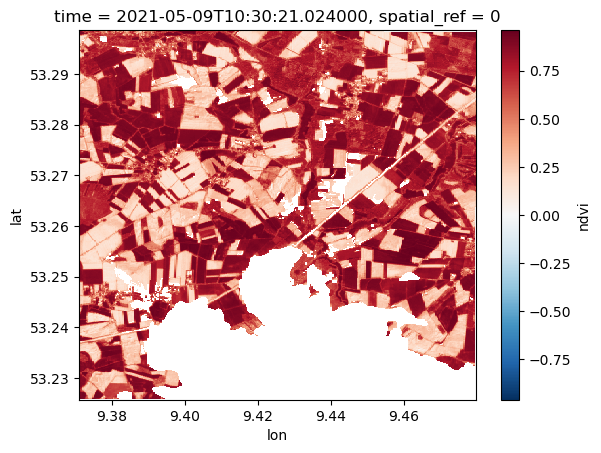

In [10]:
cube_ndvi["ndvi"].isel(time=3).plot()

### Resample in time

Resample in time dimension to eliminate outliers.

In [11]:
cube_resampled = resample_in_time(cube_ndvi, frequency="10D", method="mean")
cube_resampled

<xarray.Dataset> Size: 17MB
Dimensions:      (time: 17, lat: 406, lon: 605)
Coordinates:
    spatial_ref  int64 8B 0
  * lon          (lon) float64 5kB 9.371 9.371 9.371 9.372 ... 9.479 9.479 9.48
  * lat          (lat) float64 3kB 53.3 53.3 53.3 53.3 ... 53.23 53.23 53.23
  * time         (time) datetime64[ns] 136B 2021-05-02 2021-05-12 ... 2021-10-09
Data variables:
    ndvi_mean    (time, lat, lon) float32 17MB dask.array<chunksize=(1, 406, 605), meta=np.ndarray>
Attributes: (12/15)
    geospatial_lon_units:       degrees_east
    geospatial_lon_min:         9.37043415849624
    geospatial_lon_max:         9.480145625641596
    geospatial_lon_resolution:  0.0001508058195867079
    geospatial_lat_units:       degrees_north
    geospatial_lat_min:         53.22585905285169
    ...                         ...
    geospatial_bounds:          POLYGON((9.37043415849624 53.22585905285169, ...
    date_modified:              2025-07-25T23:37:05.108805
    stac_item_ids:              {'2021-05-02T10:40:21.024000': ['S2A_MSIL2A_2...
    stac_catalog_url:           https://stac.dataspace.copernicus.eu/v1
    time_coverage_start:        <xarray.DataArray 'time' ()> Size: 8B\narray(...
    time_coverage_end:          <xarray.DataArray 'time' ()> Size: 8B\narray(...

### Optimized Chunking for Time Series Analysis

For analysing long time series, it is benificial to chunk a dataset accordingly, so the chunks contain more values of the time dimension and less of the spatial dimensions.
More information can be found in the notebook **Chunking of Datasets**.

In [12]:
time_chunksize = 19
x_chunksize = 303 
y_chunksize = 203

In [13]:
cube_rechunked = chunk_dataset(cube_resampled,
                             {"time": time_chunksize,
                              "lat": y_chunksize,
                              "lon": x_chunksize}, 
                             format_name='zarr', 
                             data_vars_only=True) 

### Store Dataset in Team storage

In [14]:
S3_USER_STORAGE_KEY = os.environ["S3_USER_STORAGE_KEY"]
S3_USER_STORAGE_SECRET = os.environ["S3_USER_STORAGE_SECRET"]
S3_USER_STORAGE_BUCKET = os.environ["S3_USER_STORAGE_BUCKET"]

In [15]:
team_store = new_data_store(
    "s3",
    root=S3_USER_STORAGE_BUCKET,
    storage_options=dict(
        anon=False, key=S3_USER_STORAGE_KEY, secret=S3_USER_STORAGE_SECRET
    ),
)

In [16]:
list(team_store.get_data_ids())

['ESACCI-L4_GHRSST-SST-GMPE-GLOB_CDR2.0-1981-2016-v02.0-fv01.0.rechunked.zarr',
 'LC-1x720x1440-0.25deg-2.0.0-v1.zarr',
 'LC-1x720x1440-0.25deg-2.0.0-v2.zarr',
 'SST.levels',
 'SeasFireCube-8D-0.25deg-1x720x1440-3.0.0.zarr',
 'amazonas_v8.zarr',
 'amazonas_v9.zarr',
 'analysed_sst.zarr',
 'analysed_sst_2.zarr',
 'analysed_sst_3.zarr',
 'analysed_sst_4.zarr',
 'cmems_sst_v1.zarr',
 'cmems_sst_v2.zarr',
 'esa-cci-permafrost-1x1151x1641-0.1.0.zarr',
 'esa-cci-permafrost-1x1151x1641-0.4.0.zarr',
 'esa-cci-permafrost-1x1151x1641-0.5.0.zarr',
 'esa-cci-permafrost-1x1151x1641-0.6.0.zarr',
 'esa-cci-permafrost-1x1151x1641-0.7.0.zarr',
 'esa-cci-permafrost-1x1151x1641-0.8.0.zarr',
 'esa-cci-permafrost-1x1151x1641-1.0.0.zarr',
 'esa_gda-health_pakistan_ERA5_precipitation_and_temperature_testdata.zarr',
 'noise_trajectory.zarr',
 's2_ndvi_lower_saxony_10D.zarr']

In [ ]:
%%time
team_store.write_data(
    cube_rechunked, "s2_ndvi_lower_saxony_10D.zarr", replace=True
)

CPU times: user 2 μs, sys: 0 ns, total: 2 μs
Wall time: 5.25 μs


In [19]:
list(team_store.get_data_ids())

['ESACCI-L4_GHRSST-SST-GMPE-GLOB_CDR2.0-1981-2016-v02.0-fv01.0.rechunked.zarr',
 'LC-1x720x1440-0.25deg-2.0.0-v1.zarr',
 'LC-1x720x1440-0.25deg-2.0.0-v2.zarr',
 'SST.levels',
 'SeasFireCube-8D-0.25deg-1x720x1440-3.0.0.zarr',
 'amazonas_v8.zarr',
 'amazonas_v9.zarr',
 'analysed_sst.zarr',
 'analysed_sst_2.zarr',
 'analysed_sst_3.zarr',
 'analysed_sst_4.zarr',
 'cmems_sst_v1.zarr',
 'cmems_sst_v2.zarr',
 'esa-cci-permafrost-1x1151x1641-0.1.0.zarr',
 'esa-cci-permafrost-1x1151x1641-0.4.0.zarr',
 'esa-cci-permafrost-1x1151x1641-0.5.0.zarr',
 'esa-cci-permafrost-1x1151x1641-0.6.0.zarr',
 'esa-cci-permafrost-1x1151x1641-0.7.0.zarr',
 'esa-cci-permafrost-1x1151x1641-0.8.0.zarr',
 'esa-cci-permafrost-1x1151x1641-1.0.0.zarr',
 'esa_gda-health_pakistan_ERA5_precipitation_and_temperature_testdata.zarr',
 'noise_trajectory.zarr',
 's2_ndvi_lower_saxony_10D.zarr']

In [20]:
dataset = team_store.open_data("s2_ndvi_lower_saxony_10D.zarr")
dataset

<xarray.Dataset> Size: 17MB
Dimensions:      (lat: 406, lon: 605, time: 17)
Coordinates:
  * lat          (lat) float64 3kB 53.3 53.3 53.3 53.3 ... 53.23 53.23 53.23
  * lon          (lon) float64 5kB 9.371 9.371 9.371 9.372 ... 9.479 9.479 9.48
    spatial_ref  int64 8B ...
  * time         (time) datetime64[ns] 136B 2021-05-02 2021-05-12 ... 2021-10-09
Data variables:
    ndvi_mean    (time, lat, lon) float32 17MB dask.array<chunksize=(17, 203, 303), meta=np.ndarray>
Attributes: (12/15)
    date_modified:              2025-07-23T12:09:07.421326
    geospatial_bounds:          POLYGON((9.37043415849624 53.22585905285169, ...
    geospatial_bounds_crs:      CRS84
    geospatial_lat_max:         53.29845926328803
    geospatial_lat_min:         53.22585905285169
    geospatial_lat_resolution:  8.935310403046515e-05
    ...                         ...
    geospatial_lon_resolution:  0.0001508058195867079
    geospatial_lon_units:       degrees_east
    stac_catalog_url:           https://stac.dataspace.copernicus.eu/v1
    stac_item_ids:              {'2021-05-02T10:40:21.024000': ['S2A_MSIL2A_2...
    time_coverage_end:          <xarray.DataArray 'time' ()> Size: 8B\narray(...
    time_coverage_start:        <xarray.DataArray 'time' ()> Size: 8B\narray(...

---
## Access vector data from xcube geodb

Now, let's access the EuroCrops data for the study area. Set the database and retrieve an overview of the available EuroCrops collections. For the study area, located in Lower Saxony (Germany), we use the collection `DE_LS_2021_EC21`.
Additional information about this database can be found [here](https://collections.eurodatacube.com/eurocrops/).

In [21]:
geodb = GeoDBClient()

In [22]:
db = "geodb_b34bfae7-9265-4a3e-b921-06549d3c6035"

In [23]:
ds = geodb.get_my_collections(database=db)
ds

,owner,database,collection
0,geodb_b34bfae7-9265-4a3e-b921-06549d3c6035,geodb_b34bfae7-9265-4a3e-b921-06549d3c6035,AT_2021_EC21
1,geodb_b34bfae7-9265-4a3e-b921-06549d3c6035,geodb_b34bfae7-9265-4a3e-b921-06549d3c6035,BE_VLG_2021_EC21
2,geodb_b34bfae7-9265-4a3e-b921-06549d3c6035,geodb_b34bfae7-9265-4a3e-b921-06549d3c6035,DE_LS_2021_EC21
3,geodb_b34bfae7-9265-4a3e-b921-06549d3c6035,geodb_b34bfae7-9265-4a3e-b921-06549d3c6035,DE_NRW_2021_EC21
4,geodb_b34bfae7-9265-4a3e-b921-06549d3c6035,geodb_b34bfae7-9265-4a3e-b921-06549d3c6035,DK_2019_EC21
5,geodb_b34bfae7-9265-4a3e-b921-06549d3c6035,geodb_b34bfae7-9265-4a3e-b921-06549d3c6035,EE_2021_EC21
6,geodb_b34bfae7-9265-4a3e-b921-06549d3c6035,geodb_b34bfae7-9265-4a3e-b921-06549d3c6035,ES_NA_2020_EC21
7,geodb_b34bfae7-9265-4a3e-b921-06549d3c6035,geodb_b34bfae7-9265-4a3e-b921-06549d3c6035,FR_2018_EC21
8,geodb_b34bfae7-9265-4a3e-b921-06549d3c6035,geodb_b34bfae7-9265-4a3e-b921-06549d3c6035,HR_2020_EC21
9,geodb_b34bfae7-9265-4a3e-b921-06549d3c6035,geodb_b34bfae7-9265-4a3e-b921-06549d3c6035,LT_2021_EC


Retrieve the entries from the collection that fall within the bounding box of the study area. Additional filters can be applied using the `where` clause.
Besides `.get_collection_by_bbox()`, there are other methods available to query the collection. You can find examples in the notebook **Access vector data with GeoDB**.

In [24]:
gdf = geodb.get_collection_by_bbox(
    collection="DE_LS_2021_EC21",
    bbox=bbox,
    comparison_mode="contains",
    #where="ec_hcat_c='3301010301'",
    bbox_crs=4326,
    offset=10,
    database=db,
)

Select only the croptypes with more than 100 field geometries.

In [25]:
croptypes = gdf.groupby("ec_hcat_n").size()[lambda x: x > 100].index.tolist()
croptypes

['grain_maize_corn_popcorn',
 'green_silo_maize',
 'pasture_meadow_grassland_grass',
 'winter_rye']

### Align to reference system of raster and vector data

As both datasets aren't in the same reference system, let's reproject the vector data to the crs of the raster data.

In [26]:
print(gdf.crs)

EPSG:25832


In [27]:
gdf = gdf.to_crs(epsg=4326)
print(gdf.crs)

EPSG:4326


<Axes: >

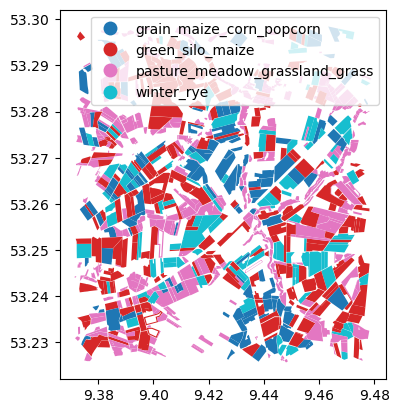

In [28]:
gdf[gdf["ec_hcat_n"].isin(croptypes)].plot(
    column="ec_hcat_n",
    legend=True,
)

---
## Extract NDVI time series

Interate through the croptypes and apply a union on the geometries of the same croptype. Then extract the NDVI time series for the different croptypes while using an arithmetic mean.

In [29]:
%%time
time_series_by_crop = {}

gm = GridMapping.from_dataset(dataset)

for croptype in croptypes:

    mask = gdf["ec_hcat_n"] == croptype
    geometry = gdf[mask].union_all()

    ts = get_time_series(
        dataset,
        gm,
        geometry=geometry,
        agg_methods='mean',
        start_date=start_time,
        end_date=end_time
    )

    if ts is not None and "ndvi_mean_mean" in ts:
        time_series_by_crop[croptype] = ts["ndvi_mean_mean"]
        

CPU times: user 893 ms, sys: 3.94 ms, total: 897 ms
Wall time: 1.23 s


Plot the NDVI time series.

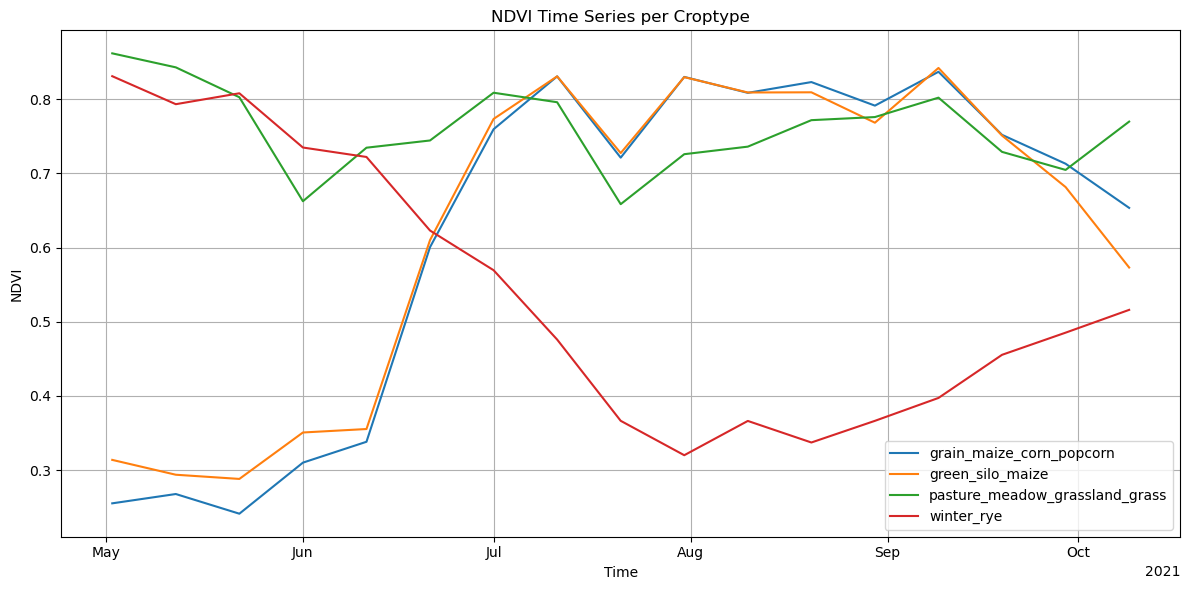

CPU times: user 1.05 s, sys: 47.4 ms, total: 1.1 s
Wall time: 2.19 s


In [30]:
%%time
plt.figure(figsize=(12, 6))

for crop, series in time_series_by_crop.items():
    series.plot(label=crop)

plt.xlabel("Time")
plt.ylabel("NDVI")
plt.title("NDVI Time Series per Croptype")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Delete the dataset if needed.

In [31]:
#team_store.delete_data("s2_ndvi_lower_saxony_10D.zarr")